# **Import Library**

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import Phrases, LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from sklearn.datasets import fetch_20newsgroups

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sentence_transformers import SentenceTransformer

# **Data Loading and Exploration**

In [4]:
url = "https://storage.googleapis.com/adsp-nlp-open/data/nlp_a_6_news.json"
news_df = pd.read_json(url, orient="records", lines=True).sample(n=5000, random_state=0)

In [6]:
print(f'Shape: {news_df.shape}')
print(f'Columns: {news_df.columns}')

Shape: (5000, 5)
Columns: Index(['url', 'date', 'language', 'title', 'text'], dtype='object')


In [7]:
news_df.head()

,url,date,language,title,text
3844,https://www.kxii.com/prnewswire/2022/05/23/com...,2022-05-23,en,COMPUTEX 2022 Global Press Conference Industry...,COMPUTEX 2022 Global Press Conference Industry...
3617,https://www.bigrapidsnews.com/business/article...,2022-06-09,en,"Moderna, Roku rise; Scotts Miracle-Gro, Charle...","Moderna, Roku rise; Scotts Miracle-Gro, Charle..."
2608,https://www.devdiscourse.com/article/education...,2022-04-12,en,Create entrepreneurship ecosystem in districts...,Create entrepreneurship ecosystem in districts...
3857,https://www.seattletimes.com/seattle-news/heal...,2022-04-30,en,Connecticut Senate OKs bill that protects abor...,Connecticut Senate OKs bill that protects abor...
1595,https://www.breakinglatest.news/news/maturity-...,2022-07-24,en,"Maturity, thanks from Fabio and Adriana: “Incl...","Maturity, thanks from Fabio and Adriana: “Incl..."


# **Model Preprocessing**

In [8]:
news_df['combined_text'] = news_df.title + " " + news_df.text

In [15]:
def clean_text(corpus, spacy_pipeline, as_string=True, batch_size=500):
    """
    Cleans a sequence of text by applying simple processing techniques in batches with progress tracking.

    Args:
        corpus (Iterable): a sequence of text to be processed
        spacy_pipeline: the Spacy pipeline object for processing text
        as_string (bool): whether to return the cleaned tokens as joined strings or lists
        batch_size (int): number of documents to process per batch

    Returns:
        clean_sequence (list): a cleaned version of the original text
    """
    corpus_clean = []
    total_batches = (len(corpus) + batch_size - 1) // batch_size  # ceiling division

    for i in tqdm(range(0, len(corpus), batch_size), desc="Cleaning text (batches)", total=total_batches):
        batch = corpus[i:i + batch_size]

        try:
            docs = list(spacy_pipeline.pipe(
                batch,
                disable=["ner"],
                n_process=1  # safer for Mac/Jupyter
            ))

            for doc in tqdm(docs, desc=f"Processing batch {i // batch_size + 1}", leave=False):
                doc_tokens = [
                    token.lemma_.lower()
                    for token in doc
                    if not token.is_stop and token.is_alpha and len(token) > 1 and token.pos_ in ("NOUN", "VERB")
                ]

                if as_string:
                    corpus_clean.append(" ".join(doc_tokens))
                else:
                    corpus_clean.append(doc_tokens)

        except Exception as e:
            print(f"\nError processing batch {i // batch_size + 1}: {e}")
            continue

    return corpus_clean

In [5]:
# loading spacy model
nlp = spacy.load("en_core_web_md")

In [16]:
# Apply cleaning to the full text
normalized_corpus = clean_text(
    corpus= news_df['combined_text'].tolist(),
    spacy_pipeline= nlp,
    as_string= False
)

Cleaning text (batches): 100%|██████████| 10/10 [18:34<00:00, 111.43s/it]


In [18]:
normalized_corpus[1]

['rise',
 'fall',
 'rise',
 'fall',
 'content',
 'rise',
 'sportsopinioncolumnsletter',
 'estatearchiveseventsclassifiedsadvertisecontacte',
 'update',
 'suspect',
 'assault',
 'cooperate',
 'authority',
 'got',
 'snake',
 'racer',
 'snake',
 'report',
 'way',
 'end',
 'season',
 'penalty',
 'haunt',
 'restaurant',
 'restaurant',
 'car',
 'crash',
 'official',
 'assemble',
 'emergency',
 'exercise',
 'sophomore',
 'make',
 'claim',
 'sprinter',
 'circuit',
 'judge',
 'retire',
 'year',
 'rise',
 'falljune',
 'stock',
 'trade',
 'price',
 'change',
 'lawn',
 'garden',
 'care',
 'company',
 'slash',
 'profit',
 'forecast',
 'year',
 'cent',
 'maker',
 'can',
 'soup',
 'cookie',
 'raise',
 'revenue',
 'forecast',
 'year',
 'maker',
 'signature',
 'technology',
 'announce',
 'expand',
 'partnership',
 'drugmaker',
 'say',
 'vaccine',
 'combine',
 'shoot',
 'protection',
 'variant',
 'appear',
 'work',
 'maker',
 'datum',
 'storage',
 'device',
 'say',
 'review',
 'option',
 'separate',
 'f

In [21]:
news_df.combined_text.iloc[1]

"Moderna, Roku rise; Scotts Miracle-Gro, Charles River fall Moderna, Roku rise; Scotts Miracle-Gro, Charles River fall        Skip to main content Big Rapids Pioneer HomepageCurrently ReadingModerna, Roku rise; Scotts Miracle-Gro, Charles River fallSubscribeSubscribee-EditionSign In  homeFormsNewslettersPuzzlesNewsCoronavirusLocal NewsHeroes UnmaskedState NewsSpecial SectionsSportsLocal SportsFerris SportsState SportsOpinionColumnsLetters to the EditorObituariesSubmit an ObituaryCoronavirusCannabisPhotosWeatherReal EstateArchivesEventsClassifiedsAdvertiseContactE-EditionSubscriber Services   Most Popular Update: Suspect in assault ID'd, cooperating with authorities Got snakes? Blue racer snakes reported in Mecosta County Tough way to end the season: Penalty kicks haunt Big Rapids Michigan restaurants that have been on 'Restaurant: Impossible' Two dead in three-car crash in Grand Rapids Midland County officials assemble for emergency exercise Chippewa Hills sophomore makes her claim as 

In [ ]:
min_counts = np.insert(np.arange(5, 50, 5), 0, 2)
bigram_counts = []

for mc in min_counts:
    phraser = Phrases(normalized_corpus, min_count=mc)
    count = sum(1 for doc in phraser[normalized_corpus] for token in doc if '_' in token)
    bigram_counts.append(count)

In [26]:
bigram_counts

[475949, 398266, 329897, 255301, 149057]

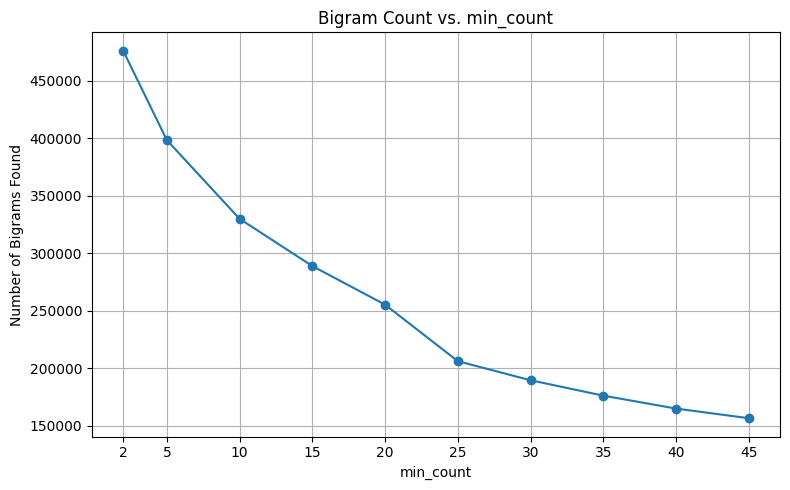

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(min_counts, bigram_counts, marker='o', linestyle='-')
plt.title('Bigram Count vs. min_count')
plt.xlabel('min_count')
plt.ylabel('Number of Bigrams Found')
plt.grid(True)
plt.xticks(min_counts)
plt.tight_layout()
plt.show()

In [30]:
# training the phrases to find bigrams
bigram_phraser = Phrases(
    normalized_corpus,
    min_count= 10)

# adding bigrams to the original unigram data
for idx in range(len(normalized_corpus)):
    for phrase in bigram_phraser[normalized_corpus[idx]]:
        if '_' in phrase:
            # phrase is a bigram, add to document.
            normalized_corpus[idx].append(phrase)

In [31]:
# a dictiohary is the mapping of an id to a word
dictionary = Dictionary(normalized_corpus)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=0.01*len(normalized_corpus), no_above=0.5)

In [32]:
[(token, idx) for token, idx in dictionary.token2id.items()][:10]

[('accelerate', 0),
 ('achieve', 1),
 ('achieve_goal', 2),
 ('adapt', 3),
 ('addition', 4),
 ('address', 5),
 ('adopt', 6),
 ('advantage', 7),
 ('agreement', 8),
 ('aim', 9)]

In [33]:
corpus = [dictionary.doc2bow(doc) for doc in normalized_corpus]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4204
Number of documents: 5000


# **Topic Modeling**

Here is where we will apply two approaches to topic modeling & identification: LDA and BERTopic.

## LDA Topic Modeling

### Inital Model

In [ ]:
num_topics = 5
chunksize = 10 
passes = 20 
iterations = 400 
eval_every = 0 

model = LdaModel(
    corpus= corpus,
    id2word= dictionary,
    chunksize= chunksize,
    alpha="auto",
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state= 42
)

In [86]:
model.show_topics()

[(0,
  '0.015*"pm" + 0.012*"official" + 0.011*"history" + 0.010*"state" + 0.010*"people" + 0.009*"point" + 0.009*"case" + 0.008*"story" + 0.008*"value" + 0.008*"read"'),
 (1,
  '0.011*"use" + 0.011*"cookie" + 0.009*"set" + 0.009*"user" + 0.009*"need" + 0.007*"feature" + 0.007*"game" + 0.007*"website" + 0.006*"come" + 0.006*"way"'),
 (2,
  '0.041*"share" + 0.034*"stock" + 0.031*"price" + 0.018*"buy" + 0.018*"quarter" + 0.015*"rate" + 0.013*"sell" + 0.012*"market" + 0.012*"report" + 0.011*"investor"'),
 (3,
  '0.000*"pound" + 0.000*"port" + 0.000*"wheel" + 0.000*"translate" + 0.000*"roof" + 0.000*"reinforce" + 0.000*"pricing" + 0.000*"outcome" + 0.000*"motor" + 0.000*"monitoring"'),
 (4,
  '0.057*"open" + 0.044*"link" + 0.035*"tab" + 0.017*"link_open" + 0.017*"join" + 0.016*"open_tab" + 0.015*"subscription" + 0.014*"people" + 0.014*"device" + 0.012*"window"'),
 (5,
  '0.000*"pound" + 0.000*"port" + 0.000*"wheel" + 0.000*"translate" + 0.000*"roof" + 0.000*"reinforce" + 0.000*"pricing" + 0

In [42]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# display
pyLDAvis.display(vis_data)

### Hyperparameter Tuning

In [ ]:
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics + 1, step_size)

coherence_scores = []

for num_topics in topics_range:
    model = LdaModel(
        corpus= corpus,
        id2word= dictionary,
        chunksize= chunksize,
        alpha= 'symmetric',
        eta= 'auto',
        iterations= iterations,
        num_topics= num_topics,
        passes= passes,
        eval_every= eval_every,
        random_state= 42
    )
    
    # Compute Coherence Score
    coherence_model = CoherenceModel(model= model, texts= normalized_corpus, dictionary= dictionary, coherence= 'c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

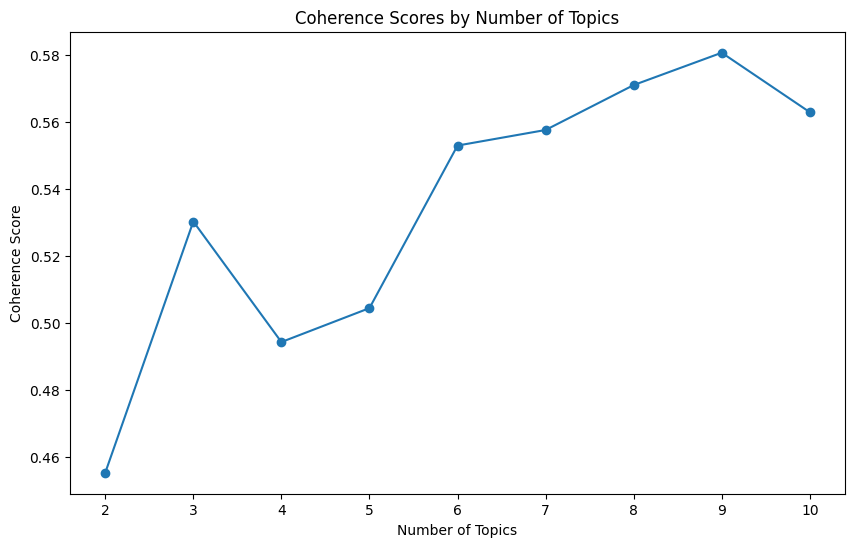

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o')
plt.title("Coherence Scores by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(topics_range)
plt.show()

In [ ]:
num_topics = 9
chunksize = 10
passes = 20
iterations = 400 
eval_every = 0  

model = LdaModel(
    corpus= corpus,
    id2word= dictionary,
    chunksize= chunksize,
    alpha= 'auto',
    eta= 'auto',
    iterations= iterations,
    num_topics= num_topics,
    passes= passes,
    eval_every= eval_every,
    random_state= 42
)

In [ ]:
model.show_topics()

[(0,
  '0.015*"pm" + 0.012*"official" + 0.011*"history" + 0.010*"state" + 0.010*"people" + 0.009*"point" + 0.009*"case" + 0.008*"story" + 0.008*"value" + 0.008*"read" + 0.008*"logo" + 0.007*"week" + 0.007*"type" + 0.006*"record" + 0.006*"decision" + 0.006*"hit" + 0.006*"man" + 0.006*"come" + 0.005*"woman" + 0.005*"war"'),
 (1,
  '0.011*"use" + 0.011*"cookie" + 0.009*"set" + 0.009*"user" + 0.009*"need" + 0.007*"feature" + 0.007*"game" + 0.007*"website" + 0.006*"come" + 0.006*"way" + 0.006*"support" + 0.006*"know" + 0.006*"email" + 0.006*"find" + 0.006*"app" + 0.006*"site" + 0.005*"launch" + 0.005*"want" + 0.005*"help" + 0.005*"deal"'),
 (2,
  '0.041*"share" + 0.034*"stock" + 0.031*"price" + 0.018*"buy" + 0.018*"quarter" + 0.015*"rate" + 0.013*"sell" + 0.012*"market" + 0.012*"report" + 0.011*"investor" + 0.010*"charge" + 0.010*"revenue" + 0.010*"analyst" + 0.010*"earning" + 0.009*"sale" + 0.009*"rating" + 0.009*"rise" + 0.008*"option" + 0.008*"trade" + 0.008*"cash"'),
 (3,
  '0.000*"outc

In [54]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# display
pyLDAvis.display(vis_data)

In [55]:
topic_words = model.show_topic(2, topn=10)
print(topic_words)

[('share', 0.041154537), ('stock', 0.033707067), ('price', 0.03148576), ('buy', 0.018369127), ('quarter', 0.017535415), ('rate', 0.015338656), ('sell', 0.013037619), ('market', 0.012368098), ('report', 0.011550327), ('investor', 0.010690923)]


# **BERTopic Modeling**

In [57]:
# instantiating the embedding model
embedding_model = SentenceTransformer("thenlper/gte-small")

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [58]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_components= 5, min_dist= 0.1, metric='cosine', random_state= 42)

In [59]:
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')

In [60]:
# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(
    stop_words="english", 
    ngram_range=(1, 2),
    min_df= 5,
    max_df= 0.9,
    max_features= 3000)

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

In [61]:
# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
)

In [62]:
topics, probs = topic_model.fit_transform(news_df["combined_text"])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [63]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1794,-1_ago_05_2022 05_https,"[ago, 05, 2022 05, https, shares, jpg, cr, qua...",[Carbon emissions in China are lower than duri...
1,0,322,0_pm_games_game_xbox,"[pm, games, game, xbox, pc, gaming, 2022 00, s...","[Stray launches on July 19, also available to ..."
2,1,260,1_markets_td_inflation_stocks,"[markets, td, inflation, stocks, fed, oil, rat...",[ECB Seen Sticking to Quarter-Point Rate Hikes...
3,2,186,2_equities_password_username_nasdaq,"[equities, password, username, nasdaq, registe...",[Petros (PTPI) falls 9.29% in Light Trading on...
4,3,184,3_seattle_seattle times_streamingcomicsgames_j...,"[seattle, seattle times, streamingcomicsgames,...",[Get ready for Seattle’s Opening Day boat para...
...,...,...,...,...,...
58,57,16,57_traded_btc_dollar_trades,"[traded, btc, dollar, trades, volume, reaches,...",[Validity Market Capitalization Tops $18.49 Mi...
59,58,15,58_internet_browser_windows_leadership,"[internet, browser, windows, leadership, edge,...","[So long, Internet Explorer. The browser retir..."
60,59,15,59_self_son_industry_software,"[self, son, industry, software, releases, dist...","[ With 22.1% CAGR, Global Digital Transforma..."
61,60,15,60_google_calendar_word_tab,"[google, calendar, word, tab, islands, new tab...",[Google Calendar will now always tell your tea...


In [64]:
topic_model.visualize_topics()

In [76]:
print(f"Number of topics: {model.num_topics}")

Number of topics: 9


In [77]:
for i in range(9):
    print(model.show_topic(i))

[('pm', 0.015258567), ('official', 0.01179248), ('history', 0.011326613), ('state', 0.009728837), ('people', 0.009651466), ('point', 0.009154193), ('case', 0.009107249), ('story', 0.008202529), ('value', 0.0079811495), ('read', 0.0075980066)]
[('use', 0.011373297), ('cookie', 0.011011524), ('set', 0.0093381), ('user', 0.009191924), ('need', 0.008605792), ('feature', 0.007443799), ('game', 0.007425346), ('website', 0.0070116566), ('come', 0.0060257073), ('way', 0.006014851)]
[('share', 0.041154537), ('stock', 0.033707067), ('price', 0.03148576), ('buy', 0.018369127), ('quarter', 0.017535415), ('rate', 0.015338656), ('sell', 0.013037619), ('market', 0.012368098), ('report', 0.011550327), ('investor', 0.010690923)]
[('pound', 0.00023786873), ('port', 0.00023786873), ('wheel', 0.00023786873), ('translate', 0.00023786873), ('roof', 0.00023786873), ('reinforce', 0.00023786873), ('pricing', 0.00023786873), ('outcome', 0.00023786873), ('motor', 0.00023786873), ('monitoring', 0.00023786873)]
[(

# **Model Evaluation**

In [78]:
lda_labels = {
    0: "Politics & History",
    1: "Technology",
    2: "Stock Market",
    3: "Poltical Economy",
    4: "Subcriptions",
    5: "Pricing Strategy",
    6: "Business Technology",
    7: "Crime News",
    8: "Entertainment"
}

In [81]:
# Build the DataFrame
lda_label_df = pd.DataFrame({
    "Topic ID": list(lda_labels.keys())
})

# Add top 10 words for each topic
top_words = []
for topic_id in lda_label_df["Topic ID"]:
    words = [word for word, _ in model.show_topic(topic_id, topn=10)]
    top_words.append(", ".join(words))

lda_label_df["Top Words"] = top_words

lda_label_df["Label"] = list(lda_labels.values())

# Display the DataFrame
display(lda_label_df)

,Topic ID,Top Words,Label
0,0,"pm, official, history, state, people, point, c...",Politics & History
1,1,"use, cookie, set, user, need, feature, game, w...",Technology
2,2,"share, stock, price, buy, quarter, rate, sell,...",Stock Market
3,3,"pound, port, wheel, translate, roof, reinforce...",Poltical Economy
4,4,"open, link, tab, link_open, join, open_tab, su...",Subcriptions
5,5,"pound, port, wheel, translate, roof, reinforce...",Pricing Strategy
6,6,"market, provide, business, technology, datum, ...",Business Technology
7,7,"video, hour, music, channel, kill, police, tal...",Crime News
8,8,"song, star, reveal, look, show, child, love, s...",Entertainment


In [82]:
bertopic_words = []
for topic_id in range(9):
    words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    bertopic_words.append(", ".join(words))

In [83]:
bertopic_words

['pm, games, game, xbox, pc, gaming, 2022 00, series, 2022 11, activision',
 'markets, td, inflation, stocks, fed, oil, rates, investors, billion, bloomberg',
 'equities, password, username, nasdaq, register, delayed, minute, mail address, financial markets, account facebook',
 'seattle, seattle times, streamingcomicsgames, justicelocal, nw, justicelocal politicseducationeducation, radioentertainmentmoviesbooksmusictheaterclassical musictv, politicseducationeducation, musictv streamingcomicsgames, musictv',
 'cloud, prnewswire, gaap, gray, customers, oracle, gray media, media group, partner, non',
 'india, delhi, rs, indian, express, singh, new window, minister, covid, khan',
 'link, new tab, opens, tab, opens new, subscription, manage, shopping, lifestyle, profile',
 'shares, nyse, llc, quarter, rating, nasdaq, management, holdings, position, company stock',
 'seattle, seattle times, musictv streamingcomicsgames, justicelocal politicseducationeducation, radioentertainmentmoviesbooksmu

In [84]:
bertopic_labels = {
    0: "Gaming",
    1: "Economic Markets",
    2: "Financial Markets",
    3: "Seattle Politics",
    4: "Cloud Computing",
    5: "India Market",
    6: "Shopping & Subscriptions",
    7: "Business Economy",
    8: "Seattle Politics"
}

In [85]:
bertopic_df = pd.DataFrame({
    "Topic ID": list(bertopic_labels.keys()),
    "Top Words": bertopic_words,
     "Label": list(bertopic_labels.values())
})

display(bertopic_df)

,Topic ID,Top Words,Label
0,0,"pm, games, game, xbox, pc, gaming, 2022 00, se...",Gaming
1,1,"markets, td, inflation, stocks, fed, oil, rate...",Economic Markets
2,2,"equities, password, username, nasdaq, register...",Financial Markets
3,3,"seattle, seattle times, streamingcomicsgames, ...",Seattle Politics
4,4,"cloud, prnewswire, gaap, gray, customers, orac...",Cloud Computing
5,5,"india, delhi, rs, indian, express, singh, new ...",India Market
6,6,"link, new tab, opens, tab, opens new, subscrip...",Shopping & Subscriptions
7,7,"shares, nyse, llc, quarter, rating, nasdaq, ma...",Business Economy
8,8,"seattle, seattle times, musictv streamingcomic...",Seattle Politics


# **Analysis**

Overall the topic modeling outputs from LDA and BERTopic are slightly different in how each model groups text topics. With LDA, we can see that the topcis are generally broader and more conceptual topics in nature. For example, “Politics & History” or “Business Technology”. However, LDA also produced some noisy/redundant topics, such as Topics 3 and 5, which appear to be somewhat unrelated. 

In contrast, BERTopic is much more granular (especially since we only pulled the first 9 of 61 topics), and is better at producing more concrete topics. For example, “Gaming,” “India Market,” or “Seattle Politics.” It also produced less redundnat topics. However, there was some thematic overlap such as "Seattle Politics". 

Overall, LDA was more high level, while BERTopic was more granular. As such, the choice between the two comes down to the interpreation goal.